## Week 4 Project

## 1.	Introduction:  
    - Let’s assume I would want to start a new business in Jersey City (or any other places), but I am not sure about what is the best business in this location that is most needed. For example, should I open a restaurant, or should I open a pharmacy, etc.?  
    - The goal is to find the best new businesses to open in Jersey City (or any other places).  
    - Clearly this would be an interesting topic to many investors and entrepreneurs


### Import Libraries

In [237]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2.	Data:  
    - Foursquare venue data for all neighborhoods in NY and Jersey City.  
    - Foursquare higher level venue catagory definition: for example, level I: Food, Level II: Asian Food, Level III: Chinese Food
    - The venue data is then reformated by one hot encoding, and averaging on neighborhood leve, such that each row in the data represents the distribution of the venue catagories in a neighborhood


### Load Map Data for New York and Jersey City

In [238]:
# with open('newyork_data.json') as json_data:
#     newyork_data = json.load(json_data)
# neighborhoods_data = newyork_data['features']
# # define the dataframe columns
# column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# # instantiate the dataframe
# neighborhoods = pd.DataFrame(columns=column_names)

In [239]:
# for data in neighborhoods_data:
#     borough = neighborhood_name = data['properties']['borough'] 
#     neighborhood_name = data['properties']['name']
        
#     neighborhood_latlon = data['geometry']['coordinates']
#     neighborhood_lat = neighborhood_latlon[1]
#     neighborhood_lon = neighborhood_latlon[0]
    
#     neighborhoods = neighborhoods.append({'Borough': borough,
#                                           'Neighborhood': neighborhood_name,
#                                           'Latitude': neighborhood_lat,
#                                           'Longitude': neighborhood_lon}, ignore_index=True)

In [240]:
# neighborhoods.to_csv('map_data_full.csv')

In [241]:
map_venues = pd.read_csv('map_data.csv')
map_venues.drop("Unnamed: 0",axis = 1,inplace = True)
print(map_venues.shape)

(313, 4)


In [242]:
map_venues["Neighborhood"] = map_venues["Borough"] + "_" + map_venues["Neighborhood"]

In [243]:
map_venues.head()

Borough                  Neighborhood   Latitude  Longitude
0  Manhattan         Manhattan_Marble Hill  40.876551 -73.910660
1  Manhattan           Manhattan_Chinatown  40.715618 -73.994279
2  Manhattan  Manhattan_Washington Heights  40.851903 -73.936900
3  Manhattan              Manhattan_Inwood  40.867684 -73.921210
4  Manhattan    Manhattan_Hamilton Heights  40.823604 -73.949688

In [244]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Display the map to verify the input data

In [245]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(map_venues['Latitude'], map_venues['Longitude'], map_venues['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Get Venue Data

#### Define Foursquare Credentials and Version

In [246]:
CLIENT_ID = 'GCYSXEPAHKWCKHMKMF4VD4U3P4ZYLSFK42YFUJI2SNB0PTTZ' # your Foursquare ID
CLIENT_SECRET = 'UEGFKNYSV0FWL0MBP3GBLHWTVAH0DYK2GI0YIJEG4I1JEQDO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GCYSXEPAHKWCKHMKMF4VD4U3P4ZYLSFK42YFUJI2SNB0PTTZ
CLIENT_SECRET:UEGFKNYSV0FWL0MBP3GBLHWTVAH0DYK2GI0YIJEG4I1JEQDO


#### Foursqure API calls

In [247]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results_temp = requests.get(url).json()["response"]
            results = results_temp['groups'][0]['items']
        except:
            #import traceback
            #traceback.print_exc()
            #input("Program crashed; press Enter to exit")
            print("Error Occured at ", name)
            #return(results_temp)
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [262]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
nearby_venues = getNearbyVenues(names=map_venues['Neighborhood'],
                                  latitudes=map_venues['Latitude'],
                                  longitudes=map_venues['Longitude']
                                 )
nearby_venues.to_csv('venue_data_full2.csv')

Manhattan_Marble Hill
Manhattan_Chinatown
Manhattan_Washington Heights
Manhattan_Inwood
Manhattan_Hamilton Heights
Manhattan_Manhattanville
Manhattan_Central Harlem
Manhattan_East Harlem
Manhattan_Upper East Side
Manhattan_Yorkville
Manhattan_Lenox Hill
Manhattan_Roosevelt Island
Manhattan_Upper West Side
Manhattan_Lincoln Square
Manhattan_Clinton
Manhattan_Midtown
Manhattan_Murray Hill
Manhattan_Chelsea
Manhattan_Greenwich Village
Manhattan_East Village
Manhattan_Lower East Side
Manhattan_Tribeca
Manhattan_Little Italy
Manhattan_Soho
Manhattan_West Village
Manhattan_Manhattan Valley
Manhattan_Morningside Heights
Manhattan_Gramercy
Manhattan_Battery Park City
Manhattan_Financial District
Manhattan_Carnegie Hill
Manhattan_Noho
Manhattan_Civic Center
Manhattan_Midtown South
Manhattan_Sutton Place
Manhattan_Turtle Bay
Manhattan_Tudor City
Manhattan_Stuyvesant Town
Manhattan_Flatiron
Manhattan_Hudson Yards
Jersey City_JC07302
Jersey City_JC07304
Jersey City_JC07306
Jersey City_JC07307
Jers

### The codes above will save the venue data into a csv file, so we can now load directly

In [263]:
nearby_venues = pd.read_csv('venue_data_full2.csv')
nearby_venues.drop("Unnamed: 0",axis = 1,inplace = True)
print(nearby_venues.shape)

(10392, 7)


In [156]:
nearby_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Manhattan_Marble Hill              40.876551               -73.91066   
1  Manhattan_Marble Hill              40.876551               -73.91066   
2  Manhattan_Marble Hill              40.876551               -73.91066   
3  Manhattan_Marble Hill              40.876551               -73.91066   
4  Manhattan_Marble Hill              40.876551               -73.91066   

      Venue Name  Venue Latitude  Venue Longitude Venue Category  
0       Arturo's       40.874412       -73.910271    Pizza Place  
1    Bikram Yoga       40.876844       -73.906204    Yoga Studio  
2  Tibbett Diner       40.880404       -73.908937          Diner  
3      Starbucks       40.877531       -73.905582    Coffee Shop  
4        Dunkin'       40.877136       -73.906666     Donut Shop

#### Foursqure Higher Level Catagories

Foursquare default venue category is too granular, let's take a look at higher levels

In [264]:
url =  "https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}".format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

results_c = requests.get(url).json()

Append higher level venue data to the original venue data file

In [265]:
venues_list = []
for results in results_c["response"]['categories']:
    for results2 in results['categories']:
        if results2['categories'] != []:
            for results3 in results2['categories']:
                if results3['categories'] != []:
                    for results4 in results3['categories']:
                        venues_list.append([results['name'],results2['name'],results3['name'],results4['name']])
                else:
                    venues_list.append([results['name'],results2['name'],results3['name'],results3['name']])    
        else:
                venues_list.append([results['name'],results2['name'],results2['name'],results2['name']])

Delete the redundant information

In [266]:
catagory_list = pd.DataFrame([venue_list for venue_list in venues_list])
catagory_list.columns = ['Level I', 'Level II','Level III','Level IV']
# catagory_list.rename(columns={"A": "Level I", "B": "Level II","B": "Level III","B": "Level IV"})

print(nearby_venues.shape)
nearby_venues_full = pd.merge(nearby_venues,catagory_list,left_on='Venue Category', right_on='Level IV',how = "left");
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 2', 'Level II 2','Level III 2']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level III 2',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level III','Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 3', 'Level II 3']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level II 3',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

catagory_list2 = catagory_list[:]
catagory_list2.drop(['Level II','Level III','Level IV'],axis = 1,inplace=True)
catagory_list2.columns = ['Level I 4']
nearby_venues_full = pd.merge(nearby_venues_full,catagory_list2,left_on='Venue Category', right_on='Level I 4',how = "left");
nearby_venues_full = nearby_venues_full.drop_duplicates();
print(nearby_venues_full.shape)

(10392, 7)
(10392, 11)
(10392, 14)
(10392, 16)
(10392, 17)


C:\ANAC\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [267]:
nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 2"][nearby_venues_full["Level I"].isnull()] 
nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 3"][nearby_venues_full["Level I"].isnull()] 
nearby_venues_full["Level I"][nearby_venues_full["Level I"].isnull()] = nearby_venues_full["Level I 4"][nearby_venues_full["Level I"].isnull()] 

nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level II 2"][nearby_venues_full["Level II"].isnull()] 
nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level II 3"][nearby_venues_full["Level II"].isnull()] 

nearby_venues_full["Level III"][nearby_venues_full["Level III"].isnull()] = nearby_venues_full["Level III 2"][nearby_venues_full["Level III"].isnull()] 

nearby_venues_full["Level II"][nearby_venues_full["Level II"].isnull()] = nearby_venues_full["Level I"][nearby_venues_full["Level II"].isnull()]
nearby_venues_full["Level III"][nearby_venues_full["Level III"].isnull()] = nearby_venues_full["Level II"][nearby_venues_full["Level III"].isnull()]
nearby_venues_full["Level IV"][nearby_venues_full["Level IV"].isnull()] = nearby_venues_full["Level III"][nearby_venues_full["Level IV"].isnull()]

nearby_venues_full.drop(['Level I 2','Level II 2','Level III 2','Level I 3','Level II 3','Level I 4'],axis = 1,inplace = True)

C:\ANAC\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ANAC\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ANAC\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ANAC\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWa

In [268]:
print(nearby_venues.shape)
nearby_venues.head()

(10392, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Manhattan_Marble Hill              40.876551               -73.91066   
1  Manhattan_Marble Hill              40.876551               -73.91066   
2  Manhattan_Marble Hill              40.876551               -73.91066   
3  Manhattan_Marble Hill              40.876551               -73.91066   
4  Manhattan_Marble Hill              40.876551               -73.91066   

      Venue Name  Venue Latitude  Venue Longitude Venue Category  
0       Arturo's       40.874412       -73.910271    Pizza Place  
1    Bikram Yoga       40.876844       -73.906204    Yoga Studio  
2  Tibbett Diner       40.880404       -73.908937          Diner  
3      Starbucks       40.877531       -73.905582    Coffee Shop  
4        Dunkin'       40.877136       -73.906666     Donut Shop

In [269]:
nearby_venues_full.isnull().any()

Neighborhood              False
Neighborhood Latitude     False
Neighborhood Longitude    False
Venue Name                False
Venue Latitude            False
Venue Longitude           False
Venue Category            False
Level I                   False
Level II                  False
Level III                 False
Level IV                  False
dtype: bool

In [270]:
print(nearby_venues_full.shape)

(10392, 11)


In [271]:
nearby_venues_full.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Manhattan_Marble Hill              40.876551               -73.91066   
1  Manhattan_Marble Hill              40.876551               -73.91066   
2  Manhattan_Marble Hill              40.876551               -73.91066   
3  Manhattan_Marble Hill              40.876551               -73.91066   
4  Manhattan_Marble Hill              40.876551               -73.91066   

      Venue Name  Venue Latitude  Venue Longitude Venue Category  \
0       Arturo's       40.874412       -73.910271    Pizza Place   
1    Bikram Yoga       40.876844       -73.906204    Yoga Studio   
2  Tibbett Diner       40.880404       -73.908937          Diner   
3      Starbucks       40.877531       -73.905582    Coffee Shop   
4        Dunkin'       40.877136       -73.906666     Donut Shop   

                 Level I            Level II             Level III  \
0                   Food         Pizza Place           Pizza Place   
1  Outdoors & Recreation  Athletics & Sports  Gym / Fitness Center   
2                   Food               Diner                 Diner   
3                   Food         Coffee Shop           Coffee Shop   
4                   Food          Donut Shop            Donut Shop   

      Level IV  
0  Pizza Place  
1  Yoga Studio  
2        Diner  
3  Coffee Shop  
4   Donut Shop

#### Data reformat

In [272]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [273]:
def dataReformat(df, column):
    num_top_venues = 5
    # one hot encoding
    data_onehot = pd.get_dummies(df[column], prefix="", prefix_sep="")
    # add neighborhood column back to dataframe
    data_onehot['Neighborhood'] = df['Neighborhood'] 
    # move neighborhood column to the first column
    fixed_columns = [data_onehot.columns[-1]] + list(data_onehot.columns[:-1])
    data_onehot = data_onehot[fixed_columns]
    
    data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
    data_grouped.head()
    
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = data_grouped['Neighborhood']

    for ind in np.arange(data_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_grouped.iloc[ind, :], num_top_venues)
    
    return [data_onehot,data_grouped,neighborhoods_venues_sorted]
    

In [274]:
[data_onehot,data_grouped,neighborhoods_venues_sorted] = dataReformat(nearby_venues_full,'Level II')

In [275]:
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(311, 6)


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0      Bronx_Allerton           Pizza Place         Deli / Bodega   
1    Bronx_Baychester            Donut Shop                  Bank   
2  Bronx_Bedford Park                 Diner    Mexican Restaurant   
3       Bronx_Belmont    Italian Restaurant     Food & Drink Shop   
4     Bronx_Bronxdale     Food & Drink Shop    Italian Restaurant   

           3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0              Food & Drink Shop      Department Store      Asian Restaurant  
1              Convenience Store        Sandwich Place     Electronics Store  
2                    Pizza Place         Deli / Bodega        Sandwich Place  
3                    Pizza Place         Deli / Bodega                Bakery  
4  Paper / Office Supplies Store                  Bank    Mexican Restaurant

In [276]:
print(data_grouped.shape)
data_grouped.head()

(311, 287)


Neighborhood  Adult Boutique  Afghan Restaurant  African Restaurant  \
0      Bronx_Allerton             0.0                0.0                 0.0   
1    Bronx_Baychester             0.0                0.0                 0.0   
2  Bronx_Bedford Park             0.0                0.0                 0.0   
3       Bronx_Belmont             0.0                0.0                 0.0   
4     Bronx_Bronxdale             0.0                0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Art Gallery  \
0             0.034483           0.0    0.00          0.0   
1             0.000000           0.0    0.05          0.0   
2             0.000000           0.0    0.00          0.0   
3             0.010526           0.0    0.00          0.0   
4             0.000000           0.0    0.00          0.0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                  0.0                   0.0          0.068966   
1                  0.0                   0.0          0.000000   
2                  0.0                   0.0          0.062500   
3                  0.0                   0.0          0.010526   
4                  0.0                   0.0          0.071429   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0            0.034483         0.0                    0.0                  0.0   
1            0.000000         0.0                    0.0                  0.0   
2            0.062500         0.0                    0.0                  0.0   
3            0.010526         0.0                    0.0                  0.0   
4            0.071429         0.0                    0.0                  0.0   

   Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  \
0          0.0            0.0              0.0        0.0         0.0   
1          0.0            0.0              0.0        0.0         0.0   
2          0.0            0.0              0.0        0.0         0.0   
3          0.0            0.0              0.0        0.0         0.0   
4          0.0            0.0              0.0        0.0         0.0   

   Bagel Shop    Bakery      Bank       Bar  Bath House  Beach  Big Box Store  \
0         0.0  0.000000  0.000000  0.000000         0.0    0.0            0.0   
1         0.0  0.000000  0.100000  0.000000         0.0    0.0            0.0   
2         0.0  0.000000  0.000000  0.031250         0.0    0.0            0.0   
3         0.0  0.052632  0.031579  0.021053         0.0    0.0            0.0   
4         0.0  0.000000  0.071429  0.000000         0.0    0.0            0.0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                       0.0        0.0         0.0     0.0         0.0   
1                       0.0        0.0         0.0     0.0         0.0   
2                       0.0        0.0         0.0     0.0         0.0   
3                       0.0        0.0         0.0     0.0         0.0   
4                       0.0        0.0         0.0     0.0         0.0   

   Boat or Ferry  Bookstore  Bowling Alley  Breakfast Spot  Brewery  \
0            0.0        0.0            0.0        0.034483      0.0   
1            0.0        0.0            0.0        0.000000      0.0   
2            0.0        0.0            0.0        0.000000      0.0   
3            0.0        0.0            0.0        0.000000      0.0   
4            0.0        0.0            0.0        0.071429      0.0   

   Bridal Shop  Bridge  Bubble Tea Shop  Buffet  Building  Burger Joint  \
0          0.0     0.0              0.0     0.0       0.0           0.0   
1          0.0     0.0              0.0     0.0       0.0           0.0   
2          0.0     0.0              0.0     0.0       0.0           0.0   
3          0.0     0.0              0.0     0.0       0.0           0.0   
4          0.0     0.0              0.0     0.0       0.0           0.0   

   Bus Station  Bus Stop  Bu

## 3.	Methodology:
    - In the last step, we've already aggregated the venue data in each neighborhood, so that we would know the distributions of venues within each neighborhood. This data will be used as input data.
    - Run K Means algorithm to divide the neighborhoods into different groups. We will also test the algorithm performance with different K.
        - I've also tested other clustering algorithms, but given the high dimension, K means is the most robust choice (i.e. the outcome won't change too much with different number of clusters)
    - Pick out the group that Jersey City belongs to, and calculate the intra-cluster similarity
    - In order to find the best venue, we will iteratively add a new venue to each of the venue category in Jersey City one by one, while keeping all other venue numbers unchanged, and then update the intra-cluster similarity. 
    - The most needed business is the venue that will give us the most increment of the intra-cluster similarity. 
    - The above steps are repeated with different Ks so we can better understand the robustness of the model  
    


## Cluster Test

Find the best K in K means

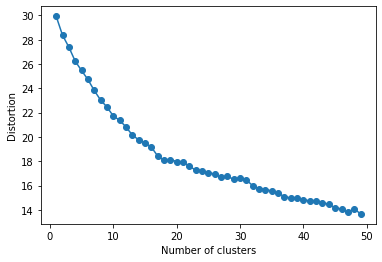

In [277]:
import matplotlib.pyplot as plt
data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
distortions = []
for i in range(1, 50):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=3000,
        tol=1e-05, random_state=0
    )
    km.fit(data_grouped_clustering+0.01)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

No clear elbow point is found, let's first take 20 as an example

In [278]:
# K Means
# set number of clusters
kclusters = 20
data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([ 2, 11,  2,  2,  2, 11, 11,  0, 11, 11])

In [279]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
data_merged = map_venues

# merge to add latitude/longitude for each neighborhood
data_merged = pd.merge(data_merged,neighborhoods_venues_sorted, on='Neighborhood',how = 'right')
print(neighborhoods_venues_sorted.shape)
print(data_merged.shape)

(311, 7)
(311, 10)


#### Visualize on Map

In [280]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data_merged['Latitude'], data_merged['Longitude'], data_merged['Neighborhood'], data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Take Jersey City 07310 as an example

In [281]:
g = data_merged["Cluster Labels"].values[data_merged["Neighborhood"] == "Jersey City_JC07310"][0]
print(data_merged[data_merged["Cluster Labels"] == g].shape)
data_merged[data_merged["Cluster Labels"] == g].head()

(55, 10)


Borough         Neighborhood   Latitude  Longitude  \
42  Jersey City  Jersey City_JC07306  40.733751 -74.065820   
44  Jersey City  Jersey City_JC07310  40.731901 -74.040200   
46        Bronx      Bronx_Wakefield  40.894705 -73.847201   
47        Bronx     Bronx_Co-op City  40.874294 -73.829939   
48        Bronx    Bronx_Eastchester  40.887556 -73.827806   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
42     Indian Restaurant     Food & Drink Shop  Fast Food Restaurant   
44    Athletics & Sports     Food & Drink Shop            Donut Shop   
46              Pharmacy          Dessert Shop        Sandwich Place   
47           Bus Station     Food & Drink Shop        Discount Store   
48  Caribbean Restaurant         Deli / Bodega           Bus Station   

   4th Most Common Venue   5th Most Common Venue  Cluster Labels  
42                  Bank             Bus Station              11  
44           Pizza Place  Furniture / Home Store              11  
46           Gas Station              Laundromat              11  
47    Salon / Barbershop              Bagel Shop              11  
48                 Diner           Train Station              11

Now let's try to find the best new business in JC 07310 -- the idea is, we will add a new venue in each of the venue catagories one by one, then we will take a look at the change in intra-cluster similiarity. The best business would be the one that results in the largest increment in the intra-cluster similarity 

Take a look at the most sensitive venue in each JC 07310

In [284]:
Neighborhood = 'Jersey City_JC07310'
#Neighborhood = 'NJ_Weehawken'
groupNumber = neighborhoods_venues_sorted["Cluster Labels"].values[neighborhoods_venues_sorted["Neighborhood"] == Neighborhood][0]
ind_Neighborhood = np.where(neighborhoods_venues_sorted['Neighborhood'][neighborhoods_venues_sorted["Cluster Labels"] == groupNumber] == Neighborhood)[0][0]
c = len(nearby_venues.loc[nearby_venues['Neighborhood'] == Neighborhood,'Neighborhood'])
data_grouped_clustering_temp = data_grouped_clustering[:]
data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
totalDistance_original = sum(dist_matrix[ind_Neighborhood,:])
totalDistance = []
for i in range(0,data_grouped_clustering.shape[1]):
    
    data_grouped_clustering_temp = data_grouped_clustering[:]
    data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
    data_with_in_group.iloc[ind_Neighborhood,i] = data_with_in_group.iloc[ind_Neighborhood,i] +1/c
    data_with_in_group.iloc[ind_Neighborhood,:] = data_with_in_group.iloc[ind_Neighborhood,:]/sum(data_with_in_group.iloc[ind_Neighborhood,:])
    dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
    totalDistance.append(sum(dist_matrix[ind_Neighborhood,:]))
    #print("New Distance: {:.4f}".format(sum(dist_matrix[ind_Neighborhood,:])))
    
    
totalDistance_sorted = sorted(totalDistance)
print("Neighborhood:",Neighborhood)
print("Original Distance: {:.3f}".format(totalDistance_original))
print("The best business is     : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],totalDistance_sorted[0]))
print("The 2nd best business is : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],totalDistance_sorted[1]))
print("The 3rd best business is : --{}--     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])],totalDistance_sorted[2]))

C:\ANAC\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\ANAC\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Neighborhood: NJ_Weehawken
Original Distance: 17.622
The best business is     : --Food & Drink Shop--     with distance reduced to 17.136
The 2nd best business is : --Fast Food Restaurant--     with distance reduced to 17.220
The 3rd best business is : --Fried Chicken Joint--     with distance reduced to 17.272


### Now let's input all above steps into a function, and loop through different Ks to check the best businesses

In [227]:
def FindBestVenues(kclusters, neighborhoods_venues_sorted, map_venues,outputDF,Neighborhood):
    data_grouped_clustering = data_grouped.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

    # add clustering labels
    neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
    data_merged = map_venues[:]
    data_merged = pd.merge(data_merged,neighborhoods_venues_sorted, on='Neighborhood',how = 'right')

    #Neighborhood = 'Jersey City_JC07310'
    groupNumber = neighborhoods_venues_sorted["Cluster Labels"].values[neighborhoods_venues_sorted["Neighborhood"] == Neighborhood][0]
    ind_Neighborhood = np.where(neighborhoods_venues_sorted['Neighborhood'][neighborhoods_venues_sorted["Cluster Labels"] == groupNumber] == Neighborhood)[0][0]
    c = len(nearby_venues.loc[nearby_venues['Neighborhood'] == Neighborhood,'Neighborhood'])
    data_grouped_clustering_temp = data_grouped_clustering[:]
    data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
    dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
    totalDistance_original = sum(dist_matrix[ind_Neighborhood,:])
    totalDistance = []
    for i in range(0,data_grouped_clustering.shape[1]):

        data_grouped_clustering_temp = data_grouped_clustering[:]
        data_with_in_group = data_grouped_clustering_temp[neighborhoods_venues_sorted["Cluster Labels"] == groupNumber]
        data_with_in_group.iloc[ind_Neighborhood,i] = data_with_in_group.iloc[ind_Neighborhood,i] +1/c
        data_with_in_group.iloc[ind_Neighborhood,:] = data_with_in_group.iloc[ind_Neighborhood,:]/sum(data_with_in_group.iloc[ind_Neighborhood,:])
        dist_matrix = distance_matrix(data_with_in_group,data_with_in_group) 
        totalDistance.append(sum(dist_matrix[ind_Neighborhood,:]))
        #print("New Distance: {:.4f}".format(sum(dist_matrix[ind_Neighborhood,:])))


    totalDistance_sorted = sorted(totalDistance)
    print("Neighborhood:",Neighborhood)
    print("K = ",kclusters)
    print("Number of Neighborhood in the Group: ",data_with_in_group.shape[0])
    print("Original Distance: {:.3f}".format(totalDistance_original))
    print("The best business is     : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],totalDistance_sorted[0]))
    print("The 2nd best business is : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],totalDistance_sorted[1]))
    print("The 3rd best business is : -- {} --     with distance reduced to {:.3f}".format(data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])],totalDistance_sorted[2]))

    outputDF.append([kclusters,data_with_in_group.shape[0],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[0])],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[1])],data_grouped_clustering_temp.columns[totalDistance.index(totalDistance_sorted[2])]])
    return outputDF

In [285]:
outputDF = []
outputDF2 = []
for k in range(5,41):
    FindBestVenues(k, neighborhoods_venues_sorted, map_venues,outputDF,'Jersey City_JC07310')
    FindBestVenues(k, neighborhoods_venues_sorted, map_venues,outputDF2,'NJ_Weehawken')

C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  5
Number of Neighborhood in the Group:  135
Original Distance: 42.044
The best business is     : -- Pharmacy --     with distance reduced to 41.530
The 2nd best business is : -- Sandwich Place --     with distance reduced to 41.595
The 3rd best business is : -- Deli / Bodega --     with distance reduced to 41.636


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  5
Number of Neighborhood in the Group:  135
Original Distance: 45.271
The best business is     : -- Food & Drink Shop --     with distance reduced to 43.970
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 44.464
The 3rd best business is : -- Dessert Shop --     with distance reduced to 44.499


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  6
Number of Neighborhood in the Group:  69
Original Distance: 20.031
The best business is     : -- Food & Drink Shop --     with distance reduced to 19.622
The 2nd best business is : -- Pharmacy --     with distance reduced to 19.806
The 3rd best business is : -- Bus Station --     with distance reduced to 19.821


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  6
Number of Neighborhood in the Group:  105
Original Distance: 38.934
The best business is     : -- Bus Stop --     with distance reduced to 38.272
The 2nd best business is : -- Athletics & Sports --     with distance reduced to 38.310
The 3rd best business is : -- Food & Drink Shop --     with distance reduced to 38.316


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  7
Number of Neighborhood in the Group:  157
Original Distance: 45.533
The best business is     : -- Pharmacy --     with distance reduced to 44.897
The 2nd best business is : -- Bus Station --     with distance reduced to 45.047
The 3rd best business is : -- Sandwich Place --     with distance reduced to 45.048


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  7
Number of Neighborhood in the Group:  157
Original Distance: 51.300
The best business is     : -- Food & Drink Shop --     with distance reduced to 49.255
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 49.709
The 3rd best business is : -- Dessert Shop --     with distance reduced to 50.423


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  8
Number of Neighborhood in the Group:  101
Original Distance: 31.316
The best business is     : -- Pharmacy --     with distance reduced to 30.875
The 2nd best business is : -- Sandwich Place --     with distance reduced to 30.970
The 3rd best business is : -- Bus Station --     with distance reduced to 31.016


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  8
Number of Neighborhood in the Group:  101
Original Distance: 33.813
The best business is     : -- Food & Drink Shop --     with distance reduced to 32.929
The 2nd best business is : -- Athletics & Sports --     with distance reduced to 33.169
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 33.180


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  9
Number of Neighborhood in the Group:  72
Original Distance: 20.474
The best business is     : -- Food & Drink Shop --     with distance reduced to 20.121
The 2nd best business is : -- Pizza Place --     with distance reduced to 20.223
The 3rd best business is : -- Pharmacy --     with distance reduced to 20.225


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  9
Number of Neighborhood in the Group:  89
Original Distance: 29.594
The best business is     : -- Asian Restaurant --     with distance reduced to 28.872
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 29.006
The 3rd best business is : -- Athletics & Sports --     with distance reduced to 29.020


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  10
Number of Neighborhood in the Group:  61
Original Distance: 19.190
The best business is     : -- Bus Station --     with distance reduced to 18.922
The 2nd best business is : -- Caribbean Restaurant --     with distance reduced to 18.928
The 3rd best business is : -- Pharmacy --     with distance reduced to 18.985


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  10
Number of Neighborhood in the Group:  72
Original Distance: 24.233
The best business is     : -- Food & Drink Shop --     with distance reduced to 23.672
The 2nd best business is : -- Athletics & Sports --     with distance reduced to 23.804
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 23.837


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  11
Number of Neighborhood in the Group:  116
Original Distance: 34.396
The best business is     : -- Pharmacy --     with distance reduced to 33.930
The 2nd best business is : -- Sandwich Place --     with distance reduced to 34.027
The 3rd best business is : -- Deli / Bodega --     with distance reduced to 34.055


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  11
Number of Neighborhood in the Group:  116
Original Distance: 37.503
The best business is     : -- Food & Drink Shop --     with distance reduced to 36.425
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 36.659
The 3rd best business is : -- Athletics & Sports --     with distance reduced to 36.768


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  12
Number of Neighborhood in the Group:  83
Original Distance: 24.756
The best business is     : -- Pharmacy --     with distance reduced to 24.435
The 2nd best business is : -- Sandwich Place --     with distance reduced to 24.439
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 24.487


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  12
Number of Neighborhood in the Group:  83
Original Distance: 27.113
The best business is     : -- Food & Drink Shop --     with distance reduced to 26.404
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 26.519
The 3rd best business is : -- Athletics & Sports --     with distance reduced to 26.547


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  13
Number of Neighborhood in the Group:  56
Original Distance: 16.646
The best business is     : -- Caribbean Restaurant --     with distance reduced to 16.415
The 2nd best business is : -- Sandwich Place --     with distance reduced to 16.433
The 3rd best business is : -- Bus Station --     with distance reduced to 16.438


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  13
Number of Neighborhood in the Group:  67
Original Distance: 20.344
The best business is     : -- Asian Restaurant --     with distance reduced to 19.592
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 19.752
The 3rd best business is : -- Dessert Shop --     with distance reduced to 19.877


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  14
Number of Neighborhood in the Group:  85
Original Distance: 25.617
The best business is     : -- Pharmacy --     with distance reduced to 25.289
The 2nd best business is : -- Sandwich Place --     with distance reduced to 25.294
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 25.345


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  14
Number of Neighborhood in the Group:  85
Original Distance: 27.987
The best business is     : -- Food & Drink Shop --     with distance reduced to 27.260
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 27.381
The 3rd best business is : -- Athletics & Sports --     with distance reduced to 27.414


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  15
Number of Neighborhood in the Group:  97
Original Distance: 27.266
The best business is     : -- Pharmacy --     with distance reduced to 26.808
The 2nd best business is : -- Sandwich Place --     with distance reduced to 26.898
The 3rd best business is : -- Park --     with distance reduced to 26.982


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  15
Number of Neighborhood in the Group:  97
Original Distance: 29.629
The best business is     : -- Food & Drink Shop --     with distance reduced to 28.698
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 28.821
The 3rd best business is : -- Dessert Shop --     with distance reduced to 29.024


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  16
Number of Neighborhood in the Group:  85
Original Distance: 24.344
The best business is     : -- Sandwich Place --     with distance reduced to 23.988
The 2nd best business is : -- Pharmacy --     with distance reduced to 24.012
The 3rd best business is : -- Clothing Store --     with distance reduced to 24.075


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  16
Number of Neighborhood in the Group:  85
Original Distance: 26.803
The best business is     : -- Food & Drink Shop --     with distance reduced to 26.068
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 26.170
The 3rd best business is : -- Athletics & Sports --     with distance reduced to 26.210


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  17
Number of Neighborhood in the Group:  83
Original Distance: 22.667
The best business is     : -- Sandwich Place --     with distance reduced to 22.313
The 2nd best business is : -- Mexican Restaurant --     with distance reduced to 22.374
The 3rd best business is : -- Pharmacy --     with distance reduced to 22.378


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  17
Number of Neighborhood in the Group:  61
Original Distance: 18.899
The best business is     : -- Food & Drink Shop --     with distance reduced to 18.073
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 18.517
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 18.526


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  18
Number of Neighborhood in the Group:  51
Original Distance: 13.926
The best business is     : -- Food & Drink Shop --     with distance reduced to 13.671
The 2nd best business is : -- Caribbean Restaurant --     with distance reduced to 13.735
The 3rd best business is : -- Pharmacy --     with distance reduced to 13.780


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  18
Number of Neighborhood in the Group:  54
Original Distance: 16.710
The best business is     : -- Athletics & Sports --     with distance reduced to 16.263
The 2nd best business is : -- Dessert Shop --     with distance reduced to 16.304
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 16.318


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  19
Number of Neighborhood in the Group:  79
Original Distance: 21.495
The best business is     : -- Pharmacy --     with distance reduced to 21.083
The 2nd best business is : -- Sandwich Place --     with distance reduced to 21.187
The 3rd best business is : -- Pizza Place --     with distance reduced to 21.260


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  19
Number of Neighborhood in the Group:  79
Original Distance: 23.600
The best business is     : -- Food & Drink Shop --     with distance reduced to 22.841
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 22.869
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 23.076


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  20
Number of Neighborhood in the Group:  55
Original Distance: 16.418
The best business is     : -- Pharmacy --     with distance reduced to 16.160
The 2nd best business is : -- Sandwich Place --     with distance reduced to 16.184
The 3rd best business is : -- Bus Station --     with distance reduced to 16.216


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  20
Number of Neighborhood in the Group:  55
Original Distance: 17.622
The best business is     : -- Food & Drink Shop --     with distance reduced to 17.136
The 2nd best business is : -- Fast Food Restaurant --     with distance reduced to 17.220
The 3rd best business is : -- Fried Chicken Joint --     with distance reduced to 17.272


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  21
Number of Neighborhood in the Group:  66
Original Distance: 16.765
The best business is     : -- Italian Restaurant --     with distance reduced to 16.412
The 2nd best business is : -- Bar --     with distance reduced to 16.512
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 16.542


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  21
Number of Neighborhood in the Group:  43
Original Distance: 13.196
The best business is     : -- Food & Drink Shop --     with distance reduced to 12.818
The 2nd best business is : -- Fast Food Restaurant --     with distance reduced to 12.842
The 3rd best business is : -- Fried Chicken Joint --     with distance reduced to 12.888


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  22
Number of Neighborhood in the Group:  81
Original Distance: 22.293
The best business is     : -- Pharmacy --     with distance reduced to 21.869
The 2nd best business is : -- Sandwich Place --     with distance reduced to 21.940
The 3rd best business is : -- Mexican Restaurant --     with distance reduced to 22.039


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  22
Number of Neighborhood in the Group:  81
Original Distance: 24.160
The best business is     : -- Food & Drink Shop --     with distance reduced to 23.443
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 23.482
The 3rd best business is : -- Dessert Shop --     with distance reduced to 23.608


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  23
Number of Neighborhood in the Group:  43
Original Distance: 12.189
The best business is     : -- Caribbean Restaurant --     with distance reduced to 11.951
The 2nd best business is : -- Latin American Restaurant --     with distance reduced to 11.988
The 3rd best business is : -- Pharmacy --     with distance reduced to 12.012


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  23
Number of Neighborhood in the Group:  27
Original Distance: 8.218
The best business is     : -- Clothing Store --     with distance reduced to 7.967
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 8.024
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 8.035


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  24
Number of Neighborhood in the Group:  43
Original Distance: 12.064
The best business is     : -- Bus Station --     with distance reduced to 11.821
The 2nd best business is : -- Pharmacy --     with distance reduced to 11.844
The 3rd best business is : -- Sandwich Place --     with distance reduced to 11.886


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  24
Number of Neighborhood in the Group:  43
Original Distance: 12.677
The best business is     : -- Food & Drink Shop --     with distance reduced to 12.249
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 12.360
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 12.365


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  25
Number of Neighborhood in the Group:  41
Original Distance: 10.967
The best business is     : -- Sandwich Place --     with distance reduced to 10.765
The 2nd best business is : -- Pharmacy --     with distance reduced to 10.775
The 3rd best business is : -- Clothing Store --     with distance reduced to 10.801


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  25
Number of Neighborhood in the Group:  41
Original Distance: 12.086
The best business is     : -- Asian Restaurant --     with distance reduced to 11.738
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 11.748
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 11.754


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  26
Number of Neighborhood in the Group:  77
Original Distance: 21.145
The best business is     : -- Pharmacy --     with distance reduced to 20.772
The 2nd best business is : -- Sandwich Place --     with distance reduced to 20.872
The 3rd best business is : -- Mexican Restaurant --     with distance reduced to 20.913


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  26
Number of Neighborhood in the Group:  77
Original Distance: 23.861
The best business is     : -- Food & Drink Shop --     with distance reduced to 22.846
The 2nd best business is : -- Asian Restaurant --     with distance reduced to 23.215
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 23.348


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  27
Number of Neighborhood in the Group:  48
Original Distance: 12.856
The best business is     : -- Pharmacy --     with distance reduced to 12.658
The 2nd best business is : -- Sandwich Place --     with distance reduced to 12.665
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 12.696


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  27
Number of Neighborhood in the Group:  48
Original Distance: 14.266
The best business is     : -- Asian Restaurant --     with distance reduced to 13.817
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 13.849
The 3rd best business is : -- Dessert Shop --     with distance reduced to 13.900


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  28
Number of Neighborhood in the Group:  40
Original Distance: 10.925
The best business is     : -- Sandwich Place --     with distance reduced to 10.739
The 2nd best business is : -- Clothing Store --     with distance reduced to 10.741
The 3rd best business is : -- Pharmacy --     with distance reduced to 10.754


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  28
Number of Neighborhood in the Group:  40
Original Distance: 11.961
The best business is     : -- Food & Drink Shop --     with distance reduced to 11.618
The 2nd best business is : -- Fast Food Restaurant --     with distance reduced to 11.632
The 3rd best business is : -- Clothing Store --     with distance reduced to 11.644


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  29
Number of Neighborhood in the Group:  31
Original Distance: 8.449
The best business is     : -- Latin American Restaurant --     with distance reduced to 8.303
The 2nd best business is : -- Sandwich Place --     with distance reduced to 8.318
The 3rd best business is : -- Pharmacy --     with distance reduced to 8.342


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  29
Number of Neighborhood in the Group:  22
Original Distance: 6.235
The best business is     : -- Asian Restaurant --     with distance reduced to 5.985
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 6.045
The 3rd best business is : -- Bank --     with distance reduced to 6.070


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  30
Number of Neighborhood in the Group:  48
Original Distance: 12.112
The best business is     : -- Pharmacy --     with distance reduced to 11.928
The 2nd best business is : -- Mexican Restaurant --     with distance reduced to 11.929
The 3rd best business is : -- Bar --     with distance reduced to 11.937


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  30
Number of Neighborhood in the Group:  36
Original Distance: 10.781
The best business is     : -- Clothing Store --     with distance reduced to 10.466
The 2nd best business is : -- Fast Food Restaurant --     with distance reduced to 10.472
The 3rd best business is : -- Food & Drink Shop --     with distance reduced to 10.477


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  31
Number of Neighborhood in the Group:  30
Original Distance: 7.886
The best business is     : -- Clothing Store --     with distance reduced to 7.714
The 2nd best business is : -- Latin American Restaurant --     with distance reduced to 7.754
The 3rd best business is : -- Sandwich Place --     with distance reduced to 7.776


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  31
Number of Neighborhood in the Group:  30
Original Distance: 8.797
The best business is     : -- Clothing Store --     with distance reduced to 8.512
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 8.539
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 8.565


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  32
Number of Neighborhood in the Group:  58
Original Distance: 15.760
The best business is     : -- Pizza Place --     with distance reduced to 15.425
The 2nd best business is : -- Pharmacy --     with distance reduced to 15.521
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 15.587


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  32
Number of Neighborhood in the Group:  38
Original Distance: 11.213
The best business is     : -- Asian Restaurant --     with distance reduced to 10.881
The 2nd best business is : -- Dessert Shop --     with distance reduced to 10.890
The 3rd best business is : -- Food & Drink Shop --     with distance reduced to 10.913


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  33
Number of Neighborhood in the Group:  49
Original Distance: 12.675
The best business is     : -- Food & Drink Shop --     with distance reduced to 12.442
The 2nd best business is : -- Pharmacy --     with distance reduced to 12.513
The 3rd best business is : -- Italian Restaurant --     with distance reduced to 12.529


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  33
Number of Neighborhood in the Group:  37
Original Distance: 10.696
The best business is     : -- Fast Food Restaurant --     with distance reduced to 10.401
The 2nd best business is : -- Food & Drink Shop --     with distance reduced to 10.418
The 3rd best business is : -- Fried Chicken Joint --     with distance reduced to 10.438


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  34
Number of Neighborhood in the Group:  30
Original Distance: 7.794
The best business is     : -- Pharmacy --     with distance reduced to 7.633
The 2nd best business is : -- Sandwich Place --     with distance reduced to 7.654
The 3rd best business is : -- Bank --     with distance reduced to 7.682


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  34
Number of Neighborhood in the Group:  21
Original Distance: 6.739
The best business is     : -- Clothing Store --     with distance reduced to 6.561
The 2nd best business is : -- Athletics & Sports --     with distance reduced to 6.562
The 3rd best business is : -- Fast Food Restaurant --     with distance reduced to 6.599


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  35
Number of Neighborhood in the Group:  27
Original Distance: 7.042
The best business is     : -- Clothing Store --     with distance reduced to 6.846
The 2nd best business is : -- Pharmacy --     with distance reduced to 6.928
The 3rd best business is : -- Sandwich Place --     with distance reduced to 6.934


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  35
Number of Neighborhood in the Group:  16
Original Distance: 5.074
The best business is     : -- Food & Drink Shop --     with distance reduced to 4.936
The 2nd best business is : -- Bus Station --     with distance reduced to 4.944
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 4.953


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  36
Number of Neighborhood in the Group:  39
Original Distance: 10.539
The best business is     : -- Pharmacy --     with distance reduced to 10.355
The 2nd best business is : -- Sandwich Place --     with distance reduced to 10.366
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 10.369


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  36
Number of Neighborhood in the Group:  39
Original Distance: 11.515
The best business is     : -- Food & Drink Shop --     with distance reduced to 11.117
The 2nd best business is : -- Fast Food Restaurant --     with distance reduced to 11.194
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 11.224


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  37
Number of Neighborhood in the Group:  27
Original Distance: 7.426
The best business is     : -- Park --     with distance reduced to 7.282
The 2nd best business is : -- Athletics & Sports --     with distance reduced to 7.283
The 3rd best business is : -- Coffee Shop --     with distance reduced to 7.338


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  37
Number of Neighborhood in the Group:  46
Original Distance: 13.418
The best business is     : -- Food & Drink Shop --     with distance reduced to 13.027
The 2nd best business is : -- Bar --     with distance reduced to 13.067
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 13.082


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  38
Number of Neighborhood in the Group:  32
Original Distance: 8.093
The best business is     : -- Sandwich Place --     with distance reduced to 7.938
The 2nd best business is : -- Bank --     with distance reduced to 7.956
The 3rd best business is : -- Pharmacy --     with distance reduced to 7.960


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  38
Number of Neighborhood in the Group:  31
Original Distance: 8.831
The best business is     : -- Food & Drink Shop --     with distance reduced to 8.498
The 2nd best business is : -- Pizza Place --     with distance reduced to 8.588
The 3rd best business is : -- Asian Restaurant --     with distance reduced to 8.611


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  39
Number of Neighborhood in the Group:  29
Original Distance: 8.148
The best business is     : -- Athletics & Sports --     with distance reduced to 7.973
The 2nd best business is : -- Park --     with distance reduced to 8.010
The 3rd best business is : -- Coffee Shop --     with distance reduced to 8.052


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  39
Number of Neighborhood in the Group:  34
Original Distance: 10.216
The best business is     : -- Food & Drink Shop --     with distance reduced to 9.918
The 2nd best business is : -- Latin American Restaurant --     with distance reduced to 9.935
The 3rd best business is : -- Clothing Store --     with distance reduced to 9.948


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: Jersey City_JC07310
K =  40
Number of Neighborhood in the Group:  38
Original Distance: 10.537
The best business is     : -- Clothing Store --     with distance reduced to 10.360
The 2nd best business is : -- Sandwich Place --     with distance reduced to 10.380
The 3rd best business is : -- Latin American Restaurant --     with distance reduced to 10.400


C:\ANAC\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ANAC\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ANAC\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Neighborhood: NJ_Weehawken
K =  40
Number of Neighborhood in the Group:  38
Original Distance: 11.613
The best business is     : -- Athletics & Sports --     with distance reduced to 11.303
The 2nd best business is : -- Clothing Store --     with distance reduced to 11.310
The 3rd best business is : -- Dessert Shop --     with distance reduced to 11.320


### Now let's take a look at the top 3 most needed venue with different K

In [314]:
outputDF_Final = pd.DataFrame (outputDF,columns=['K','Neiborhoods in the Group','Best Business','2nd Best Business','3rd Best Business'])
outputDF_Final.head()

K  Neiborhoods in the Group      Best Business 2nd Best Business  \
0  5                       135           Pharmacy    Sandwich Place   
1  6                        69  Food & Drink Shop          Pharmacy   
2  7                       157           Pharmacy       Bus Station   
3  8                       101           Pharmacy    Sandwich Place   
4  9                        72  Food & Drink Shop       Pizza Place   

  3rd Best Business  
0     Deli / Bodega  
1       Bus Station  
2    Sandwich Place  
3       Bus Station  
4          Pharmacy

In [315]:
outputDF_Final2 = pd.DataFrame (outputDF2,columns=['K','Neiborhoods in the Group','Best Business','2nd Best Business','3rd Best Business'])
outputDF_Final2.head()

K  Neiborhoods in the Group      Best Business   2nd Best Business  \
0  5                       135  Food & Drink Shop    Asian Restaurant   
1  6                       105           Bus Stop  Athletics & Sports   
2  7                       157  Food & Drink Shop    Asian Restaurant   
3  8                       101  Food & Drink Shop  Athletics & Sports   
4  9                        89   Asian Restaurant   Food & Drink Shop   

    3rd Best Business  
0        Dessert Shop  
1   Food & Drink Shop  
2        Dessert Shop  
3    Asian Restaurant  
4  Athletics & Sports

### Let's aggregate the results of all Ks, and summarize into one single table.

#### In addition, we will also define scores for each venue in the table. For each K, we assign 3 points to the best venue, 2 points to the 2nd best, and 1 points to the 3rd, then we aggregate onto venue level

In [333]:
def findBest(outputDF_Final):
    B1 = outputDF_Final["Best Business"].value_counts().rename_axis('Venue').reset_index(name='Best') 
    B2 = outputDF_Final["2nd Best Business"].value_counts().rename_axis('Venue').reset_index(name='2nd') 
    B3 = outputDF_Final["3rd Best Business"].value_counts().rename_axis('Venue').reset_index(name='3rd') 
    Summary = pd.merge(pd.merge(B1,B2,on = "Venue",how = "outer"),B3,on = 'Venue',how = "outer")
    Summary = Summary.fillna(0);
    Summary["Final Score"] = Summary["Best"]*3 + Summary["2nd"]*2 + Summary["3rd"]*1
    Summary = Summary.sort_values(by=['Final Score'], ascending=False).reset_index()
    Summary.drop(['index'],axis = 1,inplace = True)
    return(Summary)

### 4. Results:
    - Based on the output table, the two most common business that the code is recommending are Pharmacy and Sandwich Places

In [334]:
Summary = findBest(outputDF_Final)
Summary

Venue  Best   2nd  3rd  Final Score
0                    Pharmacy  15.0   7.0  8.0         67.0
1              Sandwich Place   5.0  16.0  4.0         51.0
2              Clothing Store   3.0   1.0  2.0         13.0
3   Latin American Restaurant   1.0   2.0  6.0         13.0
4                 Bus Station   2.0   1.0  4.0         12.0
5           Food & Drink Shop   4.0   0.0  0.0         12.0
6        Caribbean Restaurant   2.0   2.0  0.0         10.0
7                 Pizza Place   1.0   1.0  1.0          6.0
8                        Park   1.0   1.0  1.0          6.0
9          Mexican Restaurant   0.0   2.0  2.0          6.0
10         Athletics & Sports   1.0   1.0  0.0          5.0
11         Italian Restaurant   1.0   0.0  1.0          4.0
12                        Bar   0.0   1.0  1.0          3.0
13                       Bank   0.0   1.0  1.0          3.0
14              Deli / Bodega   0.0   0.0  2.0          2.0
15                Coffee Shop   0.0   0.0  2.0          2.0
16           Asian Restaurant   0.0   0.0  1.0          1.0

In [335]:
Summary = findBest(outputDF_Final2)
Summary

Venue  Best   2nd  3rd  Final Score
0           Food & Drink Shop  22.0   8.0  3.0         85.0
1            Asian Restaurant   6.0  12.0  6.0         48.0
2        Fast Food Restaurant   1.0   5.0  7.0         20.0
3          Athletics & Sports   2.0   4.0  5.0         19.0
4              Clothing Store   4.0   1.0  2.0         16.0
5                Dessert Shop   0.0   2.0  7.0         11.0
6   Latin American Restaurant   0.0   1.0  2.0          4.0
7                    Bus Stop   1.0   0.0  0.0          3.0
8         Fried Chicken Joint   0.0   0.0  3.0          3.0
9                 Bus Station   0.0   1.0  0.0          2.0
10                        Bar   0.0   1.0  0.0          2.0
11                Pizza Place   0.0   1.0  0.0          2.0
12                       Bank   0.0   0.0  1.0          1.0